# FLDPLN Model for Verdigris river

In [38]:
import sys
import time
from dask.distributed import Client, LocalCluster
from dask import visualize

In [39]:
# Tool/script folder
fldplnToolFolder = r'E:\CUAHSI_SI\training\source' # tool development folder, has the latest version
# Add the tool/script folder to sys.path to access fldpln modules
sys.path.append(fldplnToolFolder) 

# fldpln module
from fldpln import *
from fldpln_library import *
from fldpln_gauge import *

In [40]:
# tiled library folder
libFolder =  r'E:\CUAHSI_SI\VerdigrisRv\projects\verdigris_10m\tiled_snz_library'

# libraries to be mapped
allLibNames = ['lib']

# Set output folder
outputFolder = r'E:\CUAHSI_SI\VerdigrisRv\projects\verdigris_10m\maps'

# Code for snapping stage to FSP - Li

In [1]:
# Wildcat Creek 3 USGS gauges (in the order from upstream to downstream)
usgsIds = ['06879805','06879810','06879815'] 
ahpsIds = ['WKCK1','MWCK1','MSTK1']

# A period between two dates: Wildcat Creek Sep.3 2018 flood event
instStages = GetUsgsGaugeStageFromWebService(usgsIds,startDate='2018-09-02',endDate='2018-09-04')
print(instStages)

# find the max stage within the time period
maxStages = instStages.groupby(['stationid'],as_index=False).agg({'stage_ft':'max'})
# find the most recent time with the max stage
tdf = pd.merge(instStages, maxStages, how='inner', on=['stationid','stage_ft'])
gaugeStagesFromNwis = tdf.groupby(['stationid'], as_index=False).agg({'stationid':'first','stage_ft':'first','stage_time':'max'})
print(gaugeStagesFromNwis)

NameError: name 'GetUsgsGaugeStageFromWebService' is not defined

In [ ]:
# Synthetic FSP gauges from NWC reach stage
# gaugeStageFileName = 'wildcat_gauges.xlsx'
# sheetName = 'ReachStageAsDof' 
gaugeStageFileName = 'wildcat_gauges_albers_meters.xlsx'
# sheetName = 'ReachMedianStage' # HAND reach median stage as DOF
sheetName = 'ReachOutletStage' # HAND reach outlet stage as DOF

# read gauge file
gaugeStages = pd.read_excel(gaugeStageFileName, sheet_name=sheetName) # 3 gauges
print(gaugeStages)

# Need to calculate gauge stage elevation if necessary!

# keep only necessary fields from gauges
keptFields = ['stationid','x','y','stage_elevation']
gaugeWithStageElevations = gaugeStages[keptFields]
print(gaugeWithStageElevations)

In [ ]:
# snap gauges to FSPs on-the-fly
print('Snap gauges to FSPs ...')
print(f'Number of gauges: {len(gaugeWithStageElevations.index)}')

# FLDPLN libraries to whose FSPs gauges are sanpped. All the libraries by default but can be a subset
libs2Map = ['lib_py']

# snap the gauges to FSPs. 
# Fields 'StrOrd','DsDist','SegId','FilledElev'are used for interpolating other FSP DOF
# Note that 'lib_name','FspX', 'FspY' together uniquely identify a FSP (as there are overlapping FSPs between libraries)!
gaugeFspDf = SnapGauges2Fsps(libFolder,libs2Map,gaugeWithStageElevations,snapDist=350,gaugeXField='x',gaugeYField='y',fspColumns=['FspX','FspY','StrOrd','DsDist','SegId','FilledElev']) 
print(gaugeFspDf)

# calculate gauge FSP's DOF
gaugeFspDf['Dof'] = gaugeFspDf['stage_elevation'] - gaugeFspDf['FilledElev']

# keep only necessary columns for gauge FSPs
gaugeFspDf = gaugeFspDf[['lib_name','FspX','FspY','StrOrd','DsDist','SegId','FilledElev','Dof']] # Note that 'lib_name','FspX', 'FspY' together uniquely identify a FSP!!!

# show info
print(f'Number of snapped gauge FSPs: {len(gaugeFspDf)}')
# Find libs where the gauges are snapped to, and they are the actual libs to map
libs2Map = gaugeFspDf['lib_name'].drop_duplicates().tolist()
print(f'Libraries gauges snapped to: {libs2Map}')
print(gaugeFspDf)

#
# save snapped gauges to CSV file for checking
# gaugeFspDf.to_csv(os.path.join(outputFolder, 'SnappedGauges.csv'), index=False)

# Functions to select and map tiles - Li

In [ ]:
def MapFloodDepthWithTiles_v1(libFolder,libName,fileFormat,outMapFolder,fspDof='MinDtf',aoiExtent=None):
# fileFormat--'snappy' or 'mat'. 'snappy' format needs to install the 'fastparquet' python package
# fspDof--Cab be 'MinDtf', 'NumOfFsps', 'Depression', a float number, and a DF of FSPs with DOF. 
#         When fspDof is a DF, it must have 3 columns ['FspX','FspY','Dof'] storing FSP's coordinates and DOF
# aoiExtent--rectangle area interested, further limits the tiles decided by the FSPs' DOF. Can be None or a list of [minX,maxX,minY,maxY], default is None.
# keepTileMaps--false or true, default is false
# 
    # create the folder for generating tile maps
    os.makedirs(outMapFolder,exist_ok=True)
    # Read lib meta data file
    metaDataFile = os.path.join(libFolder, libName, metaDataFileName)
    with open(metaDataFile,'r') as jf:
        md = json.load(jf)
    cellSize = md['CellSize']
    srText = md['SpatialReference']
    libSr = rasterio.crs.CRS.from_wkt(srText)

    # decide the tiles to map
    tileIds,fppExtents = Tiles2Map_v1(libFolder,libName,fspDof,aoiExtent=None)  #FUNCTION 1 - Tiles2Map
    print('Tiles need to be mapped:',tileIds)

    # map the selected tile
    if tileIds is None:
        tileTifs = None
    else:
        tileTifs = []
        for tid,fppExtent in zip(tileIds,fppExtents):    #FUNCTION 2 - MapOneTile
            tif=MapOneTile_v1(libFolder,libName,tid,fppExtent,cellSize,libSr,fileFormat,outMapFolder,fspDof,aoiExtent)
            if not(tif is None):
                tileTifs.append(tif)
        if not tileTifs: # empty list
            tileTifs = None
    
    return tileTifs

######################################################################################################################
def Tiles2Map_v1(libFolder,libName,fspDof='MinDtf',aoiExtent=None):
# Find the tiles need to be mapped for the library
    # Read in the fsp-tile index and tile index files for selecting tiles for mapping
    # read in fsp-tile index file to select the tiles for mapping
    fspIdxFile = os.path.join(libFolder, libName, fspTileIndexFileName)
    fspIdxDf = pd.read_csv(fspIdxFile)
    # print(fspIdxDf)

    # tile index file stores tile and FPP extents for the tile
    tileIdxFile = os.path.join(libFolder, libName, tileIndexFileName)
    tileIdxDf = pd.read_csv(tileIdxFile)
    # print(tileIdxDf)
    
    # Select the tiles for mapping based on the FSPs and fsp-tile index
    # for a dataframe of FSPs
    elif isinstance(fspDof, pd.DataFrame):
        # find which tiles need to be mapped
        fspTiles = pd.merge(fspIdxDf, fspDof, how='inner', on=['FspId'])
        # print(fspTiles)
        # select those where DOF > minDtf
        fspTiles = fspTiles[fspTiles['Dof']>fspTiles['MinDtf']]
        # print(fspTiles)
        # find the tiles need to be mapped
        # fspTiles = fspTiles['TileId'].unique()
        fspTiles = fspTiles['TileId'].drop_duplicates().sort_values().tolist()
    else:
        print(f'Unsupported fspDof type {fspDof}!')
        return

    # further limit the tiles to those that intersect with the AOI extent
    if aoiExtent is None:
        tiles = fspTiles
    
    # tiles selected
    if len(tiles) == 0:
        # print('No tile needs to be mapped!')
        return None,None
    else:
        # get each tile's fppExtent
        fppExtents=[]
        for tid in tiles:
            fppExtent = tileIdxDf[tileIdxDf['TileId']==tid].reset_index().loc[0,['FppMinX','FppMaxX','FppMinY','FppMaxY']].values.tolist()
            fppExtents.append(fppExtent)
        return tiles,fppExtents

######################################################################################################################
def MapOneTile_v1(libFolder,libName,tid,fppExtent,cellSize,libSr,fileFormat,outMapFolder,fspDof='MinDtf',aoiExtent=None):
# Map one tile as a GeoTif file   
    if fileFormat == 'snappy':
        # tileName = os.path.join(libFolder, libName, tileFileMainName+'_'+str(tid)+'.gzip') # for gzip
        tileName = os.path.join(libFolder, libName, tileFileMainName+'_'+str(tid)+'.snz') # for snappy
        tdf = pd.read_parquet(tileName) # the original column datatypes are kept when read into a DF!

    # Turn FSP-FPP relations to a 2D array
    dtfArray, noData, mapMinX, mapMaxY = TileFspFppRelations2Array_v1(tdf, fppExtent, cellSize, fspDof, aoiExtent)
    
    # map the tile
    if not (dtfArray is None): # needs to be mapped
        # Create and save map as a GeoTif file
        # print('Saving map as a TIF raster ...')
        
        # output file name
        rasterName = os.path.join(outMapFolder,libName+'_tile_'+str(tid)+'.tif')
        
        # create GeoTIFF profile
        # create an Affine transformation from upper left corner coordinates and pixel sizes
        transform = rasterio.transform.from_origin(mapMinX, mapMaxY, cellSize, cellSize)
        profile = dict(
            driver="GTiff",
            height = dtfArray.shape[0], 
            width = dtfArray.shape[1],
            count=1,
            dtype=str(dtfArray.dtype),
            crs=libSr,
            transform=transform,
            nodata=noData
        )
        
        # write to COG file
        with MemoryFile() as memfile:
            # write the array to a memory file
            with memfile.open(**profile) as mem:
                # Populate the input file with numpy array
                mem.write(dtfArray,1)
            # open the memory file reading
            with memfile.open(mode='r') as mem:
                dst_profile = cog_profiles.get("deflate")
                cog_translate(
                    mem,
                    rasterName,
                    dst_profile,
                    in_memory=True,
                    quiet=True,
                )
        return rasterName
    
        # # code to save tile as regular GeoTIFF file
        # with rasterio.open(rasterName, 'w', **profile) as tifRaster:
        #     tifRaster.write(dtfArray, 1)
        # return rasterName
    else:
        return None

######################################################################################################################
def TileFspFppRelations2Array_v1(fspFppRels, fppExtent, cellSize, fspDof='MinDtf', aoiExtent=None, noData=-9999):
# The minimum bounding extent of the FPPs in the relations is always used when create the map for the tile!
#
# FspFppRels-- a dataframe of FSP-FPP relations which have the columns of ["FspId", "FppCol", "FppRow", "Dtf", "FilledDepth"] from a tile
# fppExtent--a list of [minX, maxX, minY, maxY], FPP's external extent of the tile and is also used to locate FPP's columns and rows in map coordinate
# fspDof--Cab be 'MinDtf', 'NumOfFsps', 'Depression', a float number, and a DF of FSP depth of flow, i.e., FSP stage. 
#         When fspDof is a table, it must have 3 columns ['FspX','FspY','Dof'] storing the coordinates and "Depth of Flow" for the FSPs
# aoiExtent--None or a rectabgle extent of [minX, maxX, minY, maxY] that INTERSECTs with the fppExtent

# Returns: dtfArray, noData, mapMinX, mapMinY

    tdf = fspFppRels
    # print('Number of FSP-FPP relations:', len(tdf))
    if len(tdf)==0:
        # no FPP needs to be mapping
        return None, None, None, None
    
    # Calculate pixel values at each FPP based on the types of fspDof: 'MinDtf', 'NumOfFsps', 'Depression', a constant DOF, and a list of DOF
    # Pixel value at each FPP is saved in the 'Dtf' column.
    # Map the tile with a FSP DOF df
    if isinstance(fspDof, pd.DataFrame):
        # print('Map with a list of FSPs with DOFs ...')

        # Only keep those relations whose DTF is less than or equal to the max interpolated DOF. 
        # This significantly saves memory and time when merge the relations with the DOFs!
        maxDof = fspDof['Dof'].max()
        tdf = tdf[tdf['Dtf'] < maxDof] # tdf.drop(tdf[tdf['Dtf']<=0].index, inplace=True) # saves memory than tdf = tdf[tdf['Dtf'] > 0]?
        # print('Number of relations to be mapped: ',len(tdf))
        
        # set FSP DOF column data types to speed merge
        fspDof = fspDof.astype(dtype={"FspId":np.int32,"Dof":np.float32},copy=False)

        # create index to speed up merge
        # tdf.astype(np.float32,copy=False).set_index(keys=['FspX','FspY'],inplace=True)
        # fspDof.astype(np.float32,copy=False).set_index(keys=['FspX','FspY'],inplace=True)
        # tdf = pd.merge(tdf, fspDof, how='inner', left_index=True,right_index=True)
        
        # map the FPPs whose FSPs' DOF > the MinDOF
        tdf = pd.merge(tdf, fspDof, how='inner', on=['FspId']) #.astype(np.float32,copy=False)
        
        # calculate DTF
        tdf['Dtf'] = tdf['Dof'] - tdf['Dtf']
        tdf = tdf[tdf['Dtf'] > 0] # tdf.drop(tdf[tdf['Dtf']<=0].index, inplace=True) # saves memory than tdf = tdf[tdf['Dtf'] > 0]?
                
        tdf = tdf.groupby(['FppCol', 'FppRow'],as_index=False).agg({'Dtf':'max','FilledDepth':'first'}) #Depth = ('Dtf', max),FilledDepth=('FilledDepth',first))
        # print(tdf)
        # add the depth of filled drpression
        tdf['Dtf'] = tdf['Dtf'] + tdf['FilledDepth']
        # drop 'FilledDepth'
    else:
        print(f'Unsupported fspDof type {fspDof}!')
        return None, None, None, None
    #
    # Turn relations into 2D array
    #
    if len(tdf)==0:
        # no FPP needs to be mapping
        return None, None, None, None

    # drop off not-used columns in the DF
    tdf = tdf[['FppCol','FppRow','Dtf']]
    # tdf.drop(columns=['FilledDepth'],axis=1,inplace=True)

    # Determine the minimum map extent to speed up the mapping
    # original map extent is the FPP's extent
    mapMinX,mapMaxX,mapMinY,mapMaxY = fppExtent

    # further reduce map extent if FPP extent is reduced
    if (not (aoiExtent is None)) or isinstance(fspDof,(int, float)) or isinstance(fspDof, pd.DataFrame):
        # further reduce the map extent with the FPPs 
        mapMinCol,mapMaxCol = tdf['FppCol'].min(),tdf['FppCol'].max()
        mapMinRow,mapMaxRow = tdf['FppRow'].min(),tdf['FppRow'].max()
        # shift FPP's cols and rows
        tdf['FppCol'] = tdf['FppCol']-mapMinCol
        tdf['FppRow'] = tdf['FppRow']-mapMinRow
        # calculate map's new extent
        mapMaxX = mapMinX + (mapMaxCol+1)*cellSize # this line MUST before the next line as the next line changes mapMinX!
        mapMinX = mapMinX + mapMinCol*cellSize
        mapMinY = mapMaxY - (mapMaxRow+1)*cellSize # this line MUST before the next line as the next line changes mapMaxY!
        mapMaxY = mapMaxY - mapMinRow*cellSize
    
    # print('Map extent (minX, maxX, minY, maxY) :',(mapMinX, mapMaxX, mapMinY, mapMaxY))
    # Calculate map rows and columns
    tCols = int(round((mapMaxX-mapMinX)/cellSize))
    tRows = int(round((mapMaxY-mapMinY)/cellSize))
    # print(f'Turn FSP-FPP relations to a 2D array of {tRows, tCols} ...')
    
    # Initialize the array for saving as a raster
    dtfArray =  np.full(shape=(tRows,tCols),fill_value=noData,dtype=np.float32)
    
    # # update the array with FPP's DTF
    for (idx,idy,dtf) in tdf.itertuples(index=False): # itertuples() is the fastest way of iterating a df
        # idx,idy,dtf = (getattr(row,'FppCol'),getattr(row,'FppRow'),getattr(row,'Dtf')) 
        dtfArray[idy,idx] = dtf
 
    return dtfArray, noData, mapMinX, mapMaxY

# Code section - Li

In [ ]:
# Find libs with snapped gauges. They are the actual libs to map
libs2Map = gaugeFspDf['lib_name'].drop_duplicates().tolist()

# prepare the DF for storing interpolated FSP DOF
fspDof = pd.DataFrame(columns=['LibName','FspId','Dof'])

# prepare DFs for saving interpolated FSPs and their segment IDs
fspCols = fspInfoColumnNames + ['Dof']
segIdCols = ['SegId','LibName']
fsps = pd.DataFrame(columns=fspCols)
segIds =pd.DataFrame(columns=segIdCols)

# map each library
for libName in libs2Map:
    # interpolate DOF for the gauges
    # print('Interpolate FSP DOF using gauge DOF ...')
    # fspIdDof = InterpolateFspDofFromGauge(libFolder,libName,gaugeFspDf) # 'V' by default
    fspIdDof = InterpolateFspDofFromGauge(libFolder,libName,gaugeFspDf,weightingType='H') # horizontal interpolation
    fspIdDof['LibName'] = libName
    # fspDof = fspDof.append(fspIdDof[['LibName','FspId','Dof']], ignore_index=True)
    fspDof = pd.concat([fspDof,fspIdDof[['LibName','FspId','Dof']]], ignore_index=True)

    # Keep interpolated FSP DOF for saving later
    fspFile = os.path.join(libFolder, libName, fspInfoFileName)
    fspDf = pd.read_csv(fspFile) 
    fspDf = pd.merge(fspDf,fspDof,how='inner',on=['FspId'])
    # fsps = fsps.append(fspDf, ignore_index=True)
    fsps = pd.concat([fsps,fspDf], ignore_index=True)
    
    # Keep FSP segment IDs for saving later
    t =  pd.DataFrame(fspDf['SegId'].drop_duplicates().sort_values())
    t['LibName'] = libName
    # segIds = segIds.append(t, ignore_index=True)
    segIds = pd.concat([segIds,t], ignore_index=True)

# show interpolated FSPs with Dof
print(fspDof)

# save interpolated FSP DOF and their segments for checking. This block of code should be commented out if no-checking needed
# Save DOF and segment IDs to CSV files
FspDofFile = os.path.join(outputFolder, 'Interpolated_FSP_DOF.csv')
SegIdFile = os.path.join(outputFolder, 'Interpolated_SegIds.csv')
fsps.to_csv(FspDofFile, index=False)
segIds.to_csv(SegIdFile, index=False)

In [ ]:
# show mapping info
print(f'Tiled FLDPLN library folder: {libFolder}')
print(f'Map folder: {outMapFolder}')
# Find libs needs mapping
libs2Map = fspDof['LibName'].drop_duplicates().tolist()
print(f'Libraries to map: {libs2Map}')

# check running time
startTimeAllLibs = time.time()

# create a local cluster to speed up the mapping. Must be run inside "if __name__ == '__main__'"!!!
if useLocalCluster:
    # cluster = LocalCluster(n_workers=4,processes=False)
    try:
        print('Start a LocalCluster ...')
        # NOTE: set worker space (i.e., local_dir) to a folder that the LocalCluster can access. When run the script through a scheduled task, 
        # the system uses C:\Windows\system32 by default, which a typical user doesn't have the access!
        # cluster = LocalCluster(n_workers=numOfWorkers,memory_limit='32GB',local_dir="D:/projects_new/fldpln/tools") # for KARS production server (192G RAM & 8 cores)
        # cluster = LocalCluster(n_workers=numOfWorkers,processes=False) # for KARS production server (192G RAM & 8 cores)
        cluster = LocalCluster(n_workers=numOfWorkers,memory_limit='8GB',local_dir="E:\temp") # for office desktop (64G RAM & 8 cores)
        # print('Watch workers at: ',cluster.dashboard_link)
        print(f'Number of workers: {numOfWorkers}')
        client = Client(cluster)
        # print scheduler info
        # print(client.scheduler_info())
    except:
        print('Cannot create a LocalCLuster!')
        useLocalCluster = False

# dict to store lib processing time
libTime={}

# map each library
for libName in libs2Map:
    # check running time
    startTime = time.time()
    
    # select the FSPs within the lib
    fspIdDof = fspDof[fspDof['LibName']==libName][['FspId','Dof']]
    # mapping flood depth
    if useLocalCluster:
        
        print(f'Map [{libName}] using LocalCLuster ...')
        # generate a DAG
        dag,dagRoot=MapFloodDepthWithTilesAsDag(libFolder,libName,'snappy',outMapFolder,fspIdDof,aoiExtent=None)
        if dag is None:
            tileTifs = None
        else:
            # visualize DAG
            # visualize(dag)
            # Compute DAG
            tileTifs = client.get(dag, dagRoot)
            if not tileTifs: # list is empty
                tileTifs =  None
    else:
        print(f'Map {libName} ...')
        tileTifs = MapFloodDepthWithTiles(libFolder,libName,'snappy',outMapFolder,fspIdDof,aoiExtent=None)
    print(f'Actual mapped tiles: {tileTifs}')

    # Mosaic all the tiles from a library into one tif file
    if mosaicTiles and not(tileTifs is None):
        print('Mosaic tile maps ...')
        mosaicTifName = libName+'_'+outMapFolderName+'.tif'
        # Simplest implementation, may crash with very large raster
        MosaicGtifs(outMapFolder,tileTifs,mosaicTifName,keepTifs=False)
    
    # check time
    endTime = time.time()
    usedTime = round((endTime-startTime)/60,3)
    libTime[libName] = usedTime
    # print(f'{libName} processing time (minutes):', usedTime)

# Show processing time
# Individual lib processing time
print('Individual library mapping time:', libTime)
# total time
endTimeAllLibs = time.time()
print('Total processing time (minutes):', round((endTimeAllLibs-startTimeAllLibs)/60,3))

#
# Shutdown local clusters
#
if useLocalCluster:
    print('Shutdown LocalCluster ...')
    cluster.close()
    client.shutdown()
    client.close()
    useLocalCluster = False

# Code modification
In FLDPLN code, the procedure first snap and interpolate stage between FSPs and later, given the value, map the corresponding FPPs. For the method proposed, technically this interpolation step should be performed after the RS edge selection and later, deriving the stage that generates the DoF close to zero at the FPP.

*Steps*

1. Load "clean edge" raster
2. Snap raster to .bil or similar
3. Extract X,Y coordinates of edge pixels into a df
4. Open FLDPLN_tiled_tile_index.csv to extract info of .snz tiles and edge pixel locations.

In [91]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import rasterio
from rasterio.warp import reproject, Resampling

In [141]:
# Step 1 and 2
def snap_raster(src_path, ref_path, dst_path):
    with rasterio.open(ref_path) as ref_src:
        ref_transform = ref_src.transform
        ref_crs = ref_src.crs
        ref_width = ref_src.width
        ref_height = ref_src.height

    with rasterio.open(src_path) as src:
        profile = src.profile
        profile.update({
            'crs': ref_crs,
            'transform': ref_transform,
            'width': ref_width,
            'height': ref_height
        })

        with rasterio.open(dst_path, 'w', **profile) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.nearest
                )
                
src_path = 'E:/CUAHSI_SI/VerdigrisRv/projects/verdigris_10m/Test/true_edge_prj.tif'
ref_path = 'E:/CUAHSI_SI/VerdigrisRv/projects/verdigris_10m/bil/dem.bil'
dst_path = 'E:/CUAHSI_SI/VerdigrisRv/projects/verdigris_10m/Test/true_edge_alig1.tif'
snap_raster(src_path, ref_path, dst_path)

In [142]:
# Step 3
def extract_coordinates(raster_path, value):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        transform = src.transform

    rows, cols = np.where(data == value)
    xs, ys = rasterio.transform.xy(transform, rows, cols)

    df = pd.DataFrame({
        'X_coord': xs,
        'Y_coord': ys
    })
    return df

snapped_raster_path = dst_path
value_to_extract = 1
RS_edges = extract_coordinates(snapped_raster_path, value_to_extract)

# Display the first few rows of the dataframe
print(RS_edges.head())

    X_coord    Y_coord
0  792445.0  4150845.0
1  792455.0  4150845.0
2  792445.0  4150835.0
3  792435.0  4150825.0
4  792425.0  4150815.0


In [143]:
#Step 4.1
# Load the tile index CSV file
tile_index_path = 'E:/CUAHSI_SI/VerdigrisRv/projects/verdigris_10m/tiled_snz_library/lib/FLDPLN_tiled_tile_index.csv'
tile_index_df = pd.read_csv(tile_index_path)
cell_size = 10
hcs = cell_size / 2
# Function to find the tile ID for a given FPP coordinate
def find_tile_id_and_indices(x, y, tile_index_df, cell_size):
    for idx, row in tile_index_df.iterrows():
        if row['TileMinX'] < x < row['TileMaxX'] and row['TileMinY'] < y < row['TileMaxY']:
            fpp_col = int((x - (row['TileMinX'] + hcs)) / cell_size)
            fpp_row = int(((row['TileMaxY'] - hcs) - y) / cell_size)
            return row['TileId'], fpp_col, fpp_row
    return None, None, None
    
# Apply the function to each row in the coordinates DataFrame
RS_edges[['TileId', 'FppCol', 'FppRow']] = RS_edges.apply(
    lambda row: pd.Series(find_tile_id_and_indices(row['X_coord'], row['Y_coord'], tile_index_df,cell_size)), axis=1)

# Display the first few rows of the DataFrame with Tile IDs and FppCols/FppRows
print(RS_edges.head())

    X_coord    Y_coord  TileId  FppCol  FppRow
0  792445.0  4150845.0    10.0   421.0   328.0
1  792455.0  4150845.0    10.0   422.0   328.0
2  792445.0  4150835.0    10.0   421.0   329.0
3  792435.0  4150825.0    10.0   420.0   330.0
4  792425.0  4150815.0    10.0   419.0   331.0


In [109]:
fsp_gdf1 = fsp_gdf.loc[fsp_gdf['FspId'] == 25464]
fsp_gdf1 

,FspId,FspX,FspY,SegId,FilledElev,DsDist,StrOrd,geometry
0,25464,788655,4130815,61,225.053833,70876.790001,5.0,POINT (788655.000 4130815.000)


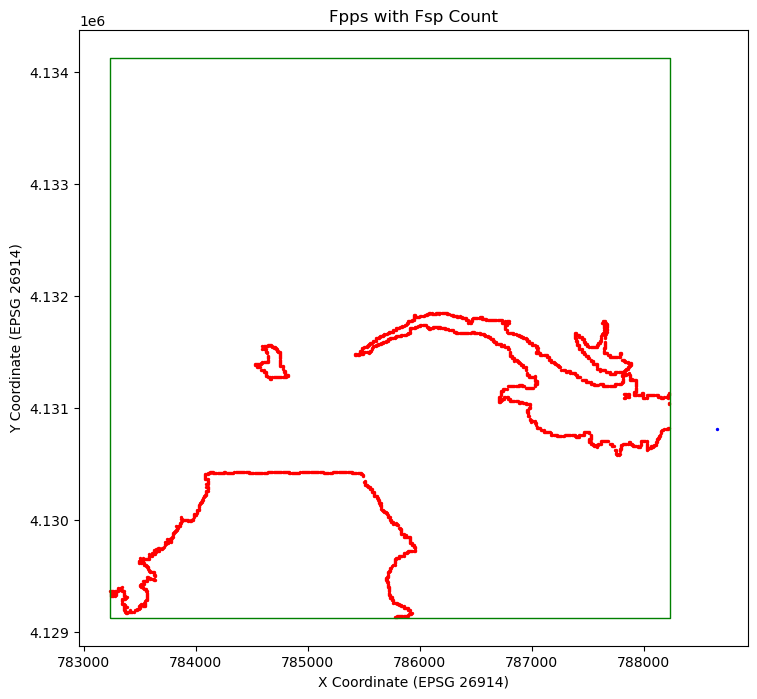

In [122]:
#Step X - Map Fpp from RS and corresponfing fpp_col,fpp_row in tile extent
from shapely.geometry import Polygon
fsp_gdf1 = fsp_gdf.loc[fsp_gdf['FspId'] == 25464]

# Filter the DataFrame
Tile = 1
RS_edges_filtered = RS_edges.loc[RS_edges['TileId'] == Tile,['X_coord','Y_coord']]
gdfRS_edges_filtered = gpd.GeoDataFrame(RS_edges_filtered, geometry=gpd.points_from_xy(RS_edges_filtered['X_coord'], RS_edges_filtered['Y_coord']))
gdfRS_edges_filtered.set_crs(epsg=26914, inplace=True)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdfRS_edges_filtered.plot(color='red', markersize=2, ax=ax)
fsp_gdf1.plot(color='blue', markersize=2, ax=ax)
row = tile_index_df.loc[tile_index_df['TileId'] == Tile, ['TileMinX', 'TileMaxX', 'TileMinY', 'TileMaxY']]
if not row.empty:
    minx,maxx,miny,maxy = row.iloc[0]

rectangle = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])
rec = gpd.GeoDataFrame([1], geometry=[rectangle], crs="EPSG:26914")
rec.plot(ax=ax, edgecolor='green', markersize=1, facecolor='none')

# Set plot title and labels
ax.set_title('Fpps with Fsp Count')
ax.set_xlabel('X Coordinate (EPSG 26914)')
ax.set_ylabel('Y Coordinate (EPSG 26914)')

plt.show()

In [144]:
#Step 4.2
# Function to load a specific .snz (parquet) file based on TileId using pandas
def load_snz_file(tile_id):
    snz_path = f'E:/CUAHSI_SI/VerdigrisRv/projects/verdigris_10m/tiled_snz_library/lib/FLDPLN_tiled_{tile_id}.snz'
    return pd.read_parquet(snz_path)

# Get unique tile IDs needed for the coordinates
dummy = RS_edges['TileId'].dropna().unique()
unique_tile_ids = dummy.astype(int)
print('Tiles to load: '+str(unique_tile_ids))
# Load data for each required tile
tile_data = {}
for tile_id in unique_tile_ids:
    tile_data[tile_id] = load_snz_file(tile_id)

## Function to get the FspIds and Dtfs for a specific coordinate from the loaded tile data
def get_fspids_and_dtfs_for_coordinate(fpp_col, fpp_row, tile_id, tile_data):
    tile_df = tile_data.get(tile_id)
    if tile_df is not None:
        results = tile_df[(tile_df['FppCol'] == fpp_col) & (tile_df['FppRow'] == fpp_row)]
        if not results.empty:
            return results['FspId'].tolist(), results['Dtf'].tolist(), results['FilledDepth'].tolist()
    return [], [], []

# Apply the data extraction function to each row in the coordinates DataFrame
RS_edges[['FspIds', 'Dtfs', 'FilledDepth']] = RS_edges.apply(
    lambda row: pd.Series(get_fspids_and_dtfs_for_coordinate(row['FppCol'], row['FppRow'], row['TileId'], tile_data)), axis=1)

# Display the first rows of the DataFrame with extracted FspIds
print(RS_edges.head())

Tiles to load: [10  3 22 21  9 20  8  7 19 18  6  1 40 39  5 17 29  4 16 28 15 27 50 37
 26 36 25 35 43 34 24]
    X_coord    Y_coord  TileId  FppCol  FppRow FspIds Dtfs FilledDepth
0  792445.0  4150845.0    10.0   421.0   328.0     []   []          []
1  792455.0  4150845.0    10.0   422.0   328.0     []   []          []
2  792445.0  4150835.0    10.0   421.0   329.0     []   []          []
3  792435.0  4150825.0    10.0   420.0   330.0     []   []          []
4  792425.0  4150815.0    10.0   419.0   331.0     []   []          []


In [124]:
test1 = load_snz_file(1)
test1
dummy = test1['FspId'].dropna().unique()
unique_FspId_tile = dummy.astype(int)
related_fsps = fsp_gdf[fsp_gdf['FspId'].isin(unique_FspId_tile)]
related_fsps

,FspId,FspX,FspY,SegId,FilledElev,DsDist,StrOrd,geometry
0,25464,788655,4130815,61,225.053833,70876.790001,5.0,POINT (788655.000 4130815.000)
2107,27571,799025,4121985,64,219.531143,50742.219305,4.0,POINT (799025.000 4121985.000)
3088,35018,802975,4115945,82,221.696594,32514.633457,3.0,POINT (802975.000 4115945.000)
3454,35384,802435,4113915,83,219.596771,28204.318164,3.0,POINT (802435.000 4113915.000)
4153,36083,801635,4109765,84,214.571732,19905.403307,3.0,POINT (801635.000 4109765.000)
4154,36084,801625,4109755,85,214.571732,19891.261172,3.0,POINT (801625.000 4109755.000)
7262,70500,793175,4128445,176,221.953995,62787.824638,1.0,POINT (793175.000 4128445.000)
7271,70509,793095,4128355,177,221.888947,62664.687553,1.0,POINT (793095.000 4128355.000)
7944,71182,795225,4123595,178,219.044464,55205.671683,1.0,POINT (795225.000 4123595.000)
8325,71563,799015,4121965,179,218.953995,50712.219305,1.0,POINT (799015.000 4121965.000)


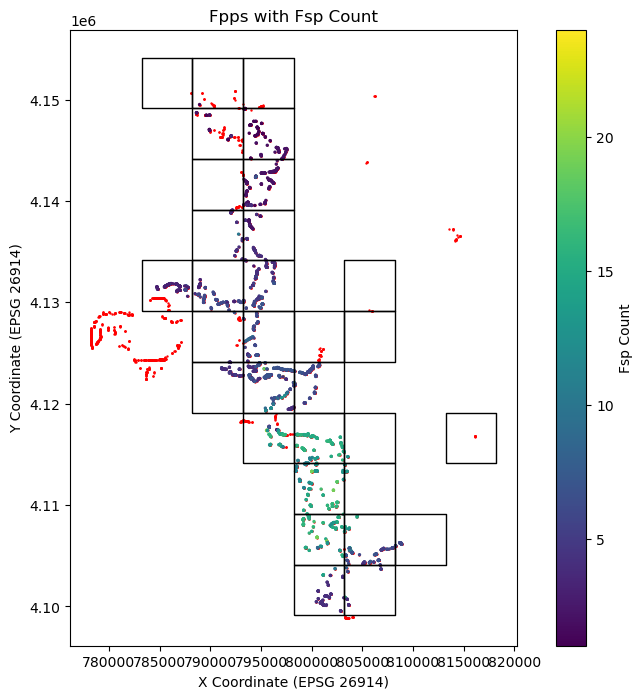

In [145]:
#Step 5 - Map a given Fpp and its Fsp
from shapely.geometry import Polygon

# Filter the DataFrame
RS_edges_filtered = RS_edges
RS_edges_filtered['NumsFSP'] = RS_edges['FspIds'].map(len)
RS_edges_filtered = RS_edges_filtered.drop(RS_edges_filtered[RS_edges_filtered['NumsFSP'] == 0].index)

# Create a GeoDataFrame
gdfRS_edges_filtered = gpd.GeoDataFrame(RS_edges_filtered, geometry=gpd.points_from_xy(RS_edges_filtered['X_coord'], RS_edges_filtered['Y_coord']))
gdfRS_edges = gpd.GeoDataFrame(RS_edges, geometry=gpd.points_from_xy(RS_edges['X_coord'], RS_edges['Y_coord']))
# Set the coordinate reference system (CRS) to EPSG 26914 for NAD UTM 14N. Chamge if required
# It is possible to load .prj from folder for this procedure but we set it here for convenience
gdfRS_edges_filtered.set_crs(epsg=26914, inplace=True)

# Normalize the FspId_count for color mapping
norm = Normalize(vmin=gdfRS_edges_filtered['NumsFSP'].min(), vmax=gdfRS_edges_filtered['NumsFSP'].max())
cmap = plt.cm.viridis

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdfRS_edges.plot(markersize=0.5, ax=ax,color='red')
gdfRS_edges_filtered.plot(column='NumsFSP', cmap=cmap, markersize=2, ax=ax, legend=False, norm=norm)
#related_fsps.plot(column='StrOrd', color='blue', markersize=1, ax=ax, legend=False, norm=norm)

for i in unique_tile_ids:
    row = tile_index_df.loc[tile_index_df['TileId'] == i, ['TileMinX', 'TileMaxX', 'TileMinY', 'TileMaxY']]
    if not row.empty:
        minx,maxx,miny,maxy = row.iloc[0]

    rectangle = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])

    # Create a GeoDataFrame
    rec = gpd.GeoDataFrame([1], geometry=[rectangle], crs="EPSG:26914")
    rec.plot(ax=ax, edgecolor='black', markersize=1, facecolor='none')

# Add a color bar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Set color bar label
cbar.set_label('Fsp Count')

# Set plot title and labels
ax.set_title('Fpps with Fsp Count')
ax.set_xlabel('X Coordinate (EPSG 26914)')
ax.set_ylabel('Y Coordinate (EPSG 26914)')

plt.show()

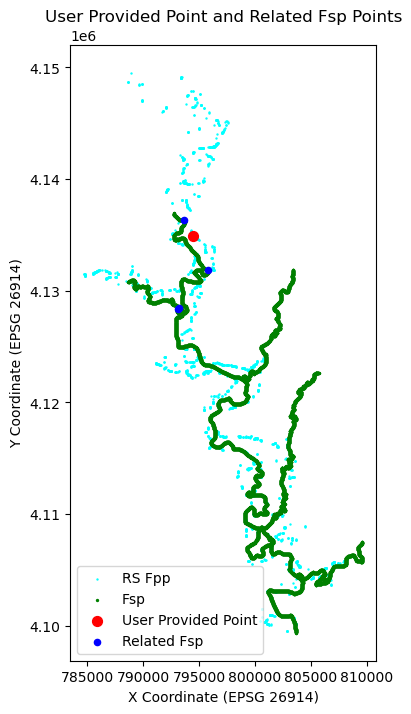

In [153]:
#Step 5.1 - Map a given Fpp and all Fsp related to it
# Function to plot the user-provided point and related Fsp points
def plot_user_point_and_fsps(user_point_index,gdf,fsp_gdf):
    user_point = gdf.iloc[user_point_index]
    related_fsp_ids = user_point['FspIds']
    related_fsps = fsp_gdf[fsp_gdf['FspId'].isin(related_fsp_ids)]
    
    # Plot the data
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Plot the user-provided point
    gdf.plot(ax=ax, color='cyan', markersize=0.5, label='RS Fpp')
    fsp_gdf.plot(ax=ax, color='green', markersize=2, label='Fsp')
    
    user_point_gdf = gpd.GeoDataFrame([user_point], geometry=[user_point.geometry])
    user_point_gdf.plot(ax=ax, color='red', markersize=50, label='User Provided Point')
    
    # Plot the related Fsp points
    related_fsps.plot(ax=ax, color='blue', markersize=20, label='Related Fsp')
    
    # Set plot title and labels
    ax.set_title('User Provided Point and Related Fsp Points')
    ax.set_xlabel('X Coordinate (EPSG 26914)')
    ax.set_ylabel('Y Coordinate (EPSG 26914)')
    
    plt.legend()
    plt.show()

# Example usage: plot the point at index 0 and its related Fsp points
fsp_info = pd.read_csv('E:/CUAHSI_SI/VerdigrisRv/projects/verdigris_10m/tiled_snz_library/lib/fsp_info.csv')
fsp_gdf = gpd.GeoDataFrame(fsp_info, geometry=gpd.points_from_xy(fsp_info['FspX'], fsp_info['FspY']))
# Set the coordinate reference system (CRS) to EPSG 26914
fsp_gdf.set_crs(epsg=26914, inplace=True)
plot_user_point_and_fsps(500,gdfRS_edges_filtered,fsp_gdf)

In [163]:
asdf1 = gdfRS_edges_filtered[gdfRS_edges_filtered['NumsFSP'] == 1]
# asdf1['FspIds'] = asdf1['FspIds'].apply(lambda x:x[0])
asdf1.groupby('FspIds').count()

TypeError: unhashable type: 'list'

In [157]:
adsf = gdfRS_edges_filtered

,X_coord,Y_coord,TileId,FppCol,FppRow,FspIds,Dtfs,FilledDepth,NumsFSP,geometry
28,788935.0,4149515.0,10.0,70.0,461.0,[68991],[13.160247802734375],[0.0],1,POINT (788935.000 4149515.000)
72,793435.0,4149125.0,21.0,20.0,0.0,[68991],[14.551651000976562],[0.0],1,POINT (793435.000 4149125.000)
73,793415.0,4149115.0,21.0,18.0,1.0,[68991],[14.701995849609375],[0.0],1,POINT (793415.000 4149115.000)
74,793425.0,4149115.0,21.0,19.0,1.0,[68991],[14.529541015625],[0.0],1,POINT (793425.000 4149115.000)
75,793405.0,4149105.0,21.0,17.0,2.0,[68991],[14.646530151367188],[0.0],1,POINT (793405.000 4149105.000)
...,...,...,...,...,...,...,...,...,...,...
3722,802845.0,4099575.0,24.0,461.0,455.0,"[43027, 76590, 78279, 78752]","[12.464462280273438, 12.464462280273438, 11.15...","[0.0, 0.0, 0.0, 0.0]",4,POINT (802845.000 4099575.000)
3723,802845.0,4099565.0,24.0,461.0,456.0,"[43027, 76590, 78279, 78752]","[12.436874389648438, 12.436874389648438, 11.12...","[0.0, 0.0, 0.0, 0.0]",4,POINT (802845.000 4099565.000)
3724,802855.0,4099555.0,24.0,462.0,457.0,"[43027, 76590, 78279, 78752]","[12.338531494140625, 12.338531494140625, 11.02...","[0.0, 0.0, 0.0, 0.0]",4,POINT (802855.000 4099555.000)
3725,802865.0,4099555.0,24.0,463.0,457.0,"[43027, 76590, 78279, 78752]","[12.3052978515625, 12.3052978515625, 10.993774...","[0.0, 0.0, 0.0, 0.0]",4,POINT (802865.000 4099555.000)


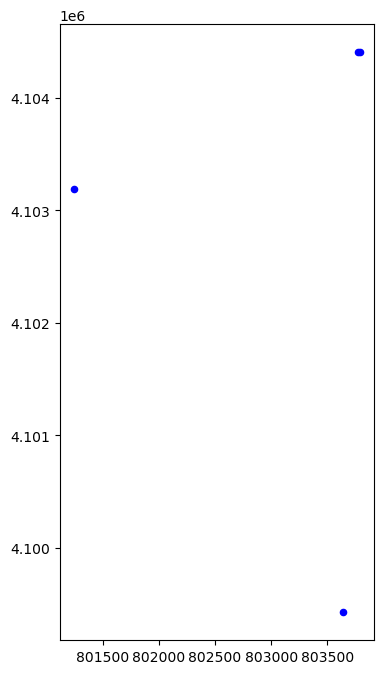

In [152]:
related_fsps1 = fsp_gdf[fsp_gdf['FspId'].isin(adsf)]
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
related_fsps1.plot(ax=ax, color='blue', markersize=20, label='Related Fsp')
plt.show()